<a href="https://colab.research.google.com/github/kundajelab/feature_interactions/blob/master/zeropadding/TrainModels_RescalePoissonLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
#download raw data
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_simulation.simdata.gz
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_neg_labels.txt.gz
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_pos_labels.txt.gz

--2020-06-25 15:05:01--  https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_simulation.simdata.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/2349aab4a9eea5e20861123641d84f04cfb8f853/zeropadding/data/train_simulation.simdata.gz [following]
--2020-06-25 15:05:01--  https://raw.githubusercontent.com/kundajelab/feature_interactions/2349aab4a9eea5e20861123641d84f04cfb8f853/zeropadding/data/train_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2104123 (2.0M) [application/octet-stream]
Saving to: ‘train_simulat

In [5]:
!gunzip *.gz

In [6]:
!md5sum *

md5sum: sample_data: Is a directory
4b333f203544ecb389fdf8114297d874  train_neg_labels.txt
306bf8d95f49454c117e664d3dc61030  train_pos_labels.txt
fb82dd3c7dc4b53d34b4fd456394de42  train_simulation.simdata


In [7]:
!pip install simdna

     |████████████████████████████████| 634kB 5.7MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done


In [2]:
import simdna
from simdna import synthetic

In [3]:
train_data = synthetic.read_simdata_file("train_simulation.simdata")

In [4]:
import numpy as np


#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_labels_and_oracle(filename):
  labels = np.array([float(x.split("\t")[0]) for
                                          x in open(filename)])
  oracle = np.array([float(x.split("\t")[1]) for
                                          x in open(filename)])
  return labels, oracle


train_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in train_data.sequences])

train_pos_labels, train_pos_oracle =\
  read_labels_and_oracle("train_pos_labels.txt")
train_neg_labels, train_neg_oracle =\
  read_labels_and_oracle("train_neg_labels.txt")

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


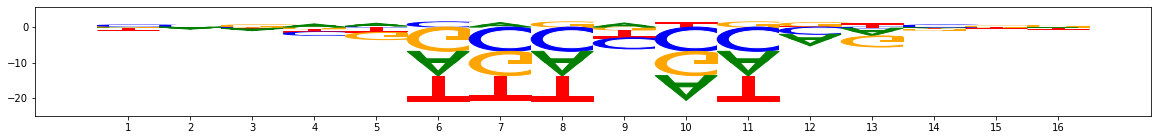

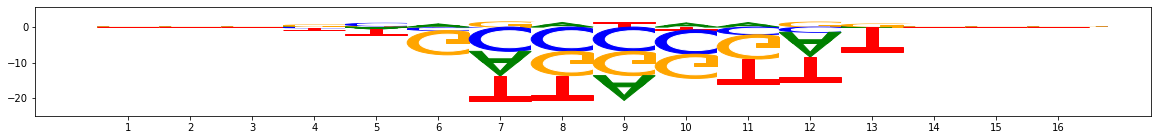

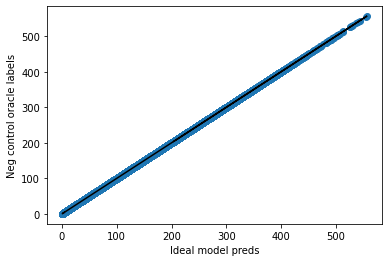

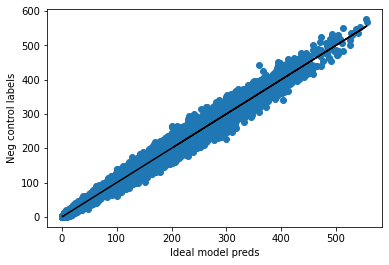

Ideal model MSE 148.36871021038954
Ideal model poisson loss -626.4052623536205


In [5]:
#Do a sanity check to make sure the "ideal" negative control model is what
# you expect it to be
from collections import OrderedDict
!pip install vizsequence
import keras
from vizsequence import viz_sequence

def convert_pwm_to_deltadeltaG(pwm):
  background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
  deltadeltaG = -np.log(pwm/np.array([background_letter_freq[x]
                              for x in ['A', 'C', 'G', 'T']])[None,:])
  return deltadeltaG

loadedMotifs = simdna.synthetic.LoadedEncodeMotifs(
      simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
pwm_GATA_orig = loadedMotifs.loadedMotifs["GATA_disc1"].getRows()
pwm_TAL_orig = loadedMotifs.loadedMotifs["TAL1_known1"].getRows()
pwm_GATA = convert_pwm_to_deltadeltaG(pwm_GATA_orig)
pwm_TAL = convert_pwm_to_deltadeltaG(pwm_TAL_orig)


#Sanity check that the ideal model is what you expect it to be
def model_arch_idealnegativecontrolmodel():
  inputs = keras.layers.Input(shape=(100,4))
  conv_layer = keras.layers.Conv1D(filters=2, kernel_size=16,
                  activation='sigmoid', padding='same')
  conv = conv_layer(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  dense_layer = keras.layers.Dense(1, kernel_initializer="he_normal")
  predictions = keras.layers.Activation("softplus")(dense_layer(conv_out))
  model = keras.models.Model(inputs=inputs,
                             outputs=predictions
                             )
  conv_layer.trainable = False
  dense_layer.trainable = False
  model.compile(optimizer='adam', loss=keras.losses.poisson,
                metrics=["mse"])
  layer_weights = np.zeros((16,4,2))
  viewing_zeros_correction = 0 #a trick to make sure that if the
  # nonzero part of the filter is looking at a zero-padded input,
  # then the filter won't fire
  layer_weights[:,:,0] = -pwm_TAL + viewing_zeros_correction
  layer_weights[3:13,:,1] = -pwm_GATA + viewing_zeros_correction
  viz_sequence.plot_weights(layer_weights[:,:,0])
  viz_sequence.plot_weights(layer_weights[:,:,1])
  conv_layer.set_weights([layer_weights,
          -np.array([len(pwm_TAL), len(pwm_GATA)])*viewing_zeros_correction])
  
  dense_layer.set_weights([np.ones((2,1)).astype("float")*10000,
                           np.zeros(1)])
  return model

idealnegcontrolmodel = model_arch_idealnegativecontrolmodel()
idealpreds = idealnegcontrolmodel.predict(train_onehot_data).squeeze()

from matplotlib import pyplot as plt
plt.scatter(idealpreds,train_neg_oracle)
plt.plot(idealpreds, idealpreds, color="black")
plt.xlabel("Ideal model preds"); plt.ylabel("Neg control oracle labels")
plt.show()
plt.scatter(idealpreds,train_neg_labels)
plt.plot(idealpreds, idealpreds, color="black")
plt.xlabel("Ideal model preds"); plt.ylabel("Neg control labels")
plt.show()

print("Ideal model MSE", np.mean(np.square(idealpreds-train_neg_labels)))
print("Ideal model poisson loss",
      np.mean(idealpreds-train_neg_labels*np.log(idealpreds)) )

Train models

In [30]:
#define model architectures

import keras
import string
import random
import numpy as np

class RescalePoissonLoss(object):

  def __init__(self, predrescale_factor):
    self.predrescale_factor = predrescale_factor
    self.name = "RescalePoisson_"+str(self.predrescale_factor)

  def __call__(self, y_true, y_pred, *args, **kwargs):
    return keras.losses.poisson(y_true, y_pred*self.predrescale_factor)
  
  def get_config(self):
        return {"n": self.predrescale_factor}

class RescaleMSE(object):
  
  def __init__(self, predrescale_factor):
    self.predrescale_factor = predrescale_factor
    self.__name__ = "RescaleMSE_"+str(self.predrescale_factor)

  def __call__(self, y_true, y_pred):
    return keras.metrics.mse(y_true=y_true, y_pred=y_pred*self.predrescale_factor)
  
  def get_config(self):
        return {"n": self.predrescale_factor}

#This model is a sanity check - it cannot learn interactions between motifs
# except ones that are within the same receptive field. I am giving it a
# wide receptive field on the first layer so it can likely learn the full
# motif properly.
def model_arch_rescalepoisson_sanitycheck(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='same',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  #
  predictions = keras.layers.Activation("softplus")(
                 keras.layers.Dense(1, kernel_initializer="he_normal",
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out))
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  rescale_factor = 100
  model.compile(optimizer='adam', loss=RescalePoissonLoss(rescale_factor),
                metrics=[RescaleMSE(rescale_factor)])
  return model

#This model can learn the ground truth via a skip connection, but also
# has the capacity to learn interactions
def model_arch_rescalepoisson_skipconn(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='same',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  output_part1 = keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  dense_1 = keras.layers.Dense(64, activation='relu',
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  output_part2 = keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(dense_1)
  combined_output = keras.layers.add([output_part1, output_part2])
  predictions = keras.layers.Activation("softplus")(combined_output)
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  rescale_factor = 100
  model.compile(optimizer='adam', loss=RescalePoissonLoss(rescale_factor),
                metrics=[RescaleMSE(rescale_factor)])
  return model


#This model has one dense layer and no slip connection
def model_arch_rescalepoisson_onelayer(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='same',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  dense_1 = keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  predictions = keras.layers.Activation("softplus")(keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(dense_1))
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  rescale_factor = 100
  model.compile(optimizer='adam', loss=RescalePoissonLoss(rescale_factor),
                metrics=[RescaleMSE(rescale_factor)])
  return model


def train_and_save_model(model_constructor, prefix, X_train, y_train,
                         X_valid, y_valid, seed):
  
  barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
  np.random.seed(seed)
  model = model_constructor()
  save_filename = prefix+"_"+barcode+".h5"
  print("Training model", save_filename)
  print(model.summary())
  model.fit(x=X_train, y=y_train, batch_size=200,
            epochs=1000,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=15,
                        restore_best_weights=True)])
  
  print("Save file name", save_filename)
  model.save(save_filename)
  return model


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!ln -s /content/drive/My\ Drive/colab_notebook_data/ .

In [9]:
!mkdir -p colab_notebook_data/feature_interactions/trained_models/zeropadding

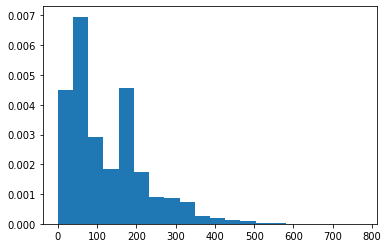

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(train_pos_labels, density=True, bins=20)
plt.show()

In [ ]:
#train the models

indices_train = np.arange(0, int(0.8 * train_onehot_data.shape[0]))
indices_valid = np.arange(int(0.8 * train_onehot_data.shape[0]),
                              train_onehot_data.shape[0])

SAVEDIR = "colab_notebook_data/feature_interactions/trained_models/zeropadding"

for seed in [100, 200, 300, 400, 500]:
  for l1_reg in [0.0, 0.00001, 0.0001]:
    for model_constructor, archname in [
              (model_arch_rescalepoisson_sanitycheck, 'rescalepoisson_sanitycheck'),
              (model_arch_rescalepoisson_skipconn, 'rescalepoisson_skipconn'),
              (model_arch_rescalepoisson_onelayer, 'rescalepoisson_onelayer')]:
        """train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/poscontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_pos_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_pos_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity"""
        
        train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/negcontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_neg_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_neg_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity

40000/40000 [==============================] - 1s 20us/step - loss: -619.5469 - RescaleMSE_100: 1478.9403 - val_loss: -619.4832 - val_RescaleMSE_100: 1617.6451
Epoch 284/1000
40000/40000 [==============================] - 1s 18us/step - loss: -619.5614 - RescaleMSE_100: 1477.5116 - val_loss: -619.5524 - val_RescaleMSE_100: 1594.3940
Epoch 285/1000
40000/40000 [==============================] - 1s 19us/step - loss: -619.5960 - RescaleMSE_100: 1466.9729 - val_loss: -619.5081 - val_RescaleMSE_100: 1615.4980
Epoch 286/1000
40000/40000 [==============================] - 1s 19us/step - loss: -619.5967 - RescaleMSE_100: 1469.4520 - val_loss: -619.6047 - val_RescaleMSE_100: 1587.6664
Epoch 287/1000
40000/40000 [==============================] - 1s 20us/step - loss: -619.6556 - RescaleMSE_100: 1454.9937 - val_loss: -619.5969 - val_RescaleMSE_100: 1591.7371
Epoch 288/1000
40000/40000 [==============================] - 1s 20us/step - loss: -619.6885 - RescaleMSE_100: 1446.2769 - val_loss: -619.67